In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Importing the dataset
df = pd.read_csv("2_shopping_trends.csv")
df

,Age,Gender,Item Purchased,Category,Location,Season,Review Rating,Discount Applied,Promo Code Used,Previous Purchases,Frequency of Purchases,Purchase Intent Category
0,33,Male,Backpack,Accessories,Malaysia,Summer,4.5,Yes,Yes,44,Fortnightly,Wants-based
1,39,Female,Jeans,Clothing,Spain,Winter,5.0,No,No,23,Fortnightly,Wants-based
2,23,Male,Dress,Clothing,Australia,Spring,3.2,No,No,30,Weekly,Wants-based
3,39,Male,Backpack,Accessories,United Kingdom,Fall,3.1,Yes,Yes,19,Weekly,Wants-based
4,34,Female,Gloves,Accessories,Nigeria,Winter,2.8,No,No,16,Annually,Wants-based
...,...,...,...,...,...,...,...,...,...,...,...,...
12939,53,Male,Sneakers,Footwear,Canada,Fall,4.4,Yes,Yes,1,NaN,Impulsive
12940,54,Male,Jewelry,Accessories,Thailand,Summer,4.3,Yes,Yes,1,NaN,Impulsive
12941,56,Female,Boots,Footwear,United States,Summer,3.8,No,No,2,NaN,Impulsive
12942,52,Female,Coat,Outerwear,Spain,Spring,3.0,No,No,2,NaN,Impulsive


In [25]:
# Drop unused columns
cleaned_df = df.copy()
cleaned_df.drop(columns=[col for col in df.columns if col not in ['Gender', 'Item Purchased', 'Category', 'Location', 'Season',
                                                                  'Discount Applied', 'Promo Code Used', 'Purchase Intent Category', 
                                                                  'Frequency of Purchases']], inplace=True)
cleaned_df

,Gender,Item Purchased,Category,Location,Season,Discount Applied,Promo Code Used,Frequency of Purchases,Purchase Intent Category
0,Male,Backpack,Accessories,Malaysia,Summer,Yes,Yes,Fortnightly,Wants-based
1,Female,Jeans,Clothing,Spain,Winter,No,No,Fortnightly,Wants-based
2,Male,Dress,Clothing,Australia,Spring,No,No,Weekly,Wants-based
3,Male,Backpack,Accessories,United Kingdom,Fall,Yes,Yes,Weekly,Wants-based
4,Female,Gloves,Accessories,Nigeria,Winter,No,No,Annually,Wants-based
...,...,...,...,...,...,...,...,...,...
12939,Male,Sneakers,Footwear,Canada,Fall,Yes,Yes,NaN,Impulsive
12940,Male,Jewelry,Accessories,Thailand,Summer,Yes,Yes,NaN,Impulsive
12941,Female,Boots,Footwear,United States,Summer,No,No,NaN,Impulsive
12942,Female,Coat,Outerwear,Spain,Spring,No,No,NaN,Impulsive


In [26]:
#check missing values
print("\nMising Value:\n",cleaned_df.isnull().sum())

#check datatype for each columns
print("\nDatatype for each column\n",cleaned_df.dtypes)

#check duplicate values
df.duplicated().sum()


Mising Value:
 Gender                         0
Item Purchased                 0
Category                       0
Location                       0
Season                         0
Discount Applied               0
Promo Code Used                0
Frequency of Purchases      9044
Purchase Intent Category       0
dtype: int64

Datatype for each column
 Gender                      object
Item Purchased              object
Category                    object
Location                    object
Season                      object
Discount Applied            object
Promo Code Used             object
Frequency of Purchases      object
Purchase Intent Category    object
dtype: object


np.int64(2056)

In [28]:
# handle missing values
cleaned_df['Frequency of Purchases'] = cleaned_df['Frequency of Purchases'].fillna(cleaned_df['Frequency of Purchases'].mode()[0])

# check missing values
print("\nMissing Value:\n",cleaned_df.isnull().sum())


Missing Value:
 Gender                      0
Item Purchased              0
Category                    0
Location                    0
Season                      0
Discount Applied            0
Promo Code Used             0
Frequency of Purchases      0
Purchase Intent Category    0
dtype: int64


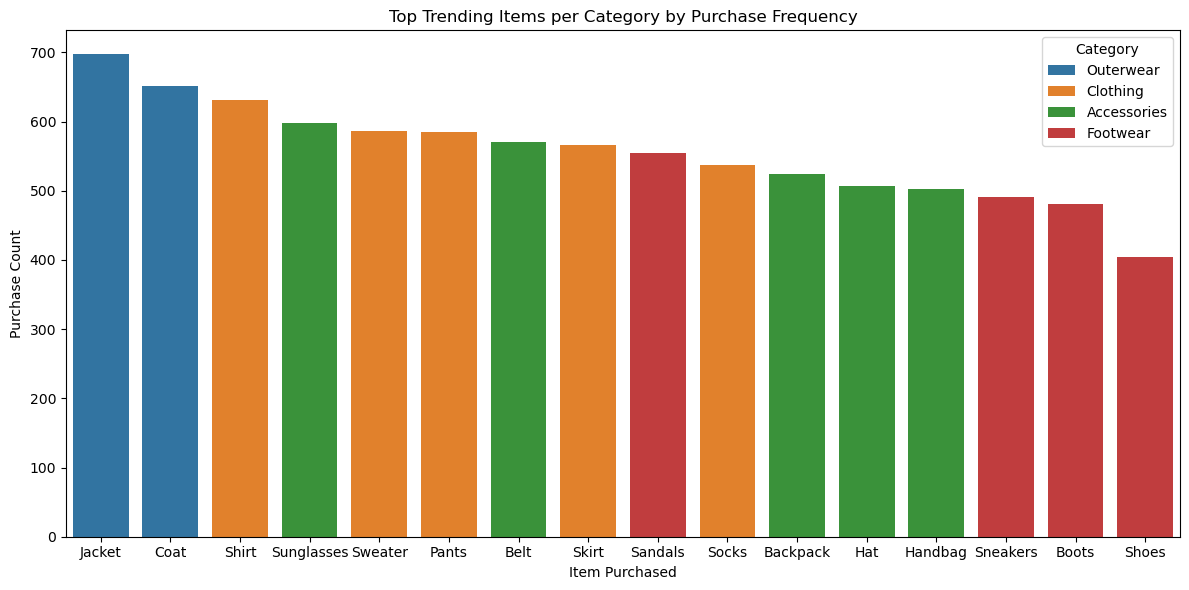

In [ ]:
# rank items by frequency per category
rank_df = cleaned_df.groupby(['Category', 'Item Purchased'])['Frequency of Purchases'].count().reset_index(name='Purchase Count')
top_items = rank_df.sort_values(by='Purchase Count', ascending=False).groupby('Category').head(5)

# visualize
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_items,
    x='Item Purchased',
    y='Purchase Count',
    hue='Category',
    dodge=False,
    palette='tab10'
)
plt.title('Top Trending Items per Category by Purchase Frequency')
plt.xlabel('Item Purchased')
plt.ylabel('Purchase Count')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

### Clustering using KMeans

In [42]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Convert categorical variables to numerical format using label encoding
cluster_df = cleaned_df[['Gender', 'Item Purchased', 'Category', 'Location', 'Season',
                         'Discount Applied', 'Promo Code Used', 'Purchase Intent Category', 
                         'Frequency of Purchases']].copy()

le_dict = {}  # Store label encoders

for column in cluster_df.columns:
    le = LabelEncoder()
    cluster_df[column] = le.fit_transform(cluster_df[column].astype(str))
    le_dict[column] = le

In [36]:
from sklearn.cluster import KMeans
import plotly.express as px
kmeans = KMeans(n_clusters=5)
cleaned_df['Cluster'] = kmeans.fit_predict(cluster_df)

In [37]:
top_items_per_cluster = (    
    cleaned_df.groupby(['Cluster', 'Item Purchased'])    
    .size()    
    .reset_index(name='Count')    
    .sort_values(['Cluster', 'Count'], ascending=[True, False])    
    .groupby('Cluster')    
    .head(5))

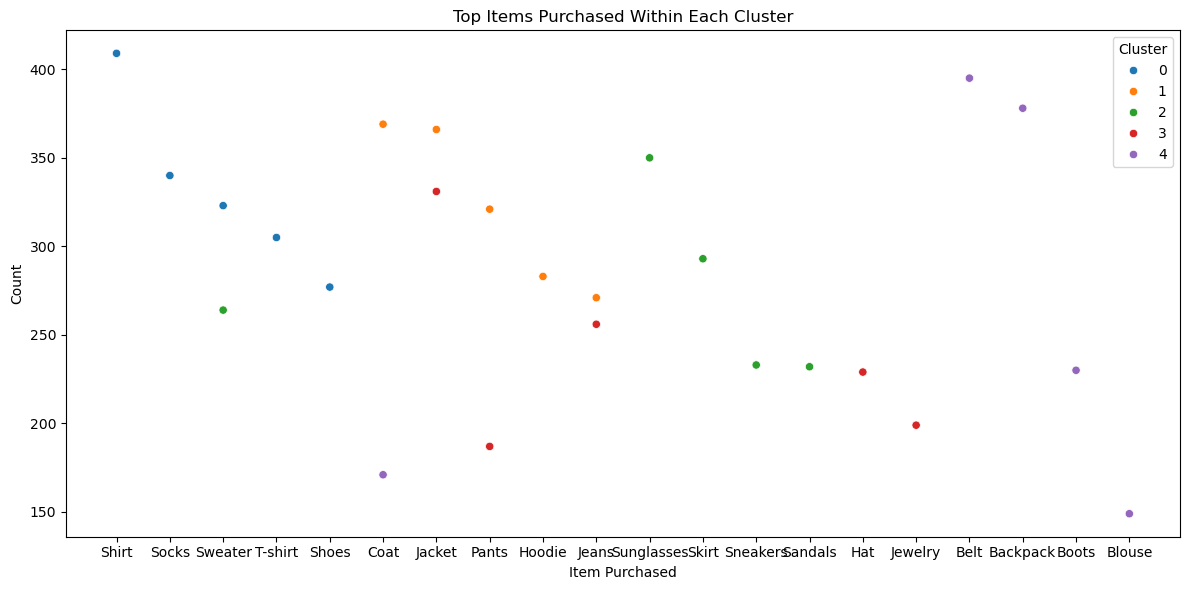

In [44]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=top_items_per_cluster,
    x='Item Purchased',
    y='Count',
    hue='Cluster',
    palette='tab10'
)
plt.title('Top Items Purchased Within Each Cluster')
plt.xlabel('Item Purchased')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [46]:
from sklearn.metrics import silhouette_score
# After fitting KMeans
inertia = kmeans.inertia_
silhouette = silhouette_score(cluster_df, kmeans.labels_)
print(f"Inertia: {inertia}")
print(f"Silhouette Score: {silhouette}")

Inertia: 349160.1351201997
Silhouette Score: 0.28641726465476186


In [ ]:
# Association Rule Mining
# Prepare data for Apriori
apriori_df = df[['Gender', 'Item Purchased', 'Category', 'Location', 'Season',
                 'Discount Applied', 'Promo Code Used', 'Purchase Intent Category', 'Frequency of Purchases']].astype(str)

transactions = apriori_df.values.tolist()
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
trans_df = pd.DataFrame(te_array, columns=te.columns_)


In [153]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Define features and target variable
feature_df = cleaned_df[['Age', 'Gender', 'Item Purchased', 'Review Rating', 'Previous Purchases', 'Category', 
                        'Location', 'Season', 'Discount Applied', 'Promo Code Used', 'Frequency of Purchases']]

x = np.asarray(feature_df)
y = np.asarray(cleaned_df['Purchase Intent Category']) # Target

# Split dataset into 80% training and 20% testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4, stratify=y)  # Stratify to balance classes

# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train) # type: ignore


### Rbf SVM

In [172]:
# Create an SVM model with
clf = SVC(kernel='rbf', C=1)

# Train the model
SvmModel = clf.fit(x_train_scaled, y_train)

# Test the model
y_pred = clf.predict(x_test_scaled)

# Evaluate model performance
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
svm_recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
svm_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("SVM Model Performance:")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1-score:", svm_f1)

SVM Model Performance:
Accuracy: 0.8838383838383839
Precision: 0.8903723463083618
Recall: 0.8838383838383839
F1-score: 0.885624065323391


### XGBoost

In [155]:
# Train XGBoost classifier
xgb_clf = XGBClassifier(eval_metric='mlogloss')
xgb_clf.fit(x_train_scaled, y_train)

# Predict on test data
y_pred = xgb_clf.predict(x_test_scaled)

# Evaluate model performance
xgboost_accuracy = accuracy_score(y_test, y_pred)
xgboost_precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
xgboost_recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
xgboost_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("XGBoost Model Performance:")
print("Accuracy:", xgboost_accuracy)
print("Precision:", xgboost_precision)
print("Recall:", xgboost_recall)
print("F1-score:", xgboost_f1)

XGBoost Model Performance:
Accuracy: 0.9820936639118457
Precision: 0.9826925199085859
Recall: 0.9820936639118457
F1-score: 0.9819957084390226


### Decision Tree

In [173]:
# Train Decision Tree model
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5, class_weight="balanced", random_state=42)
DecisionTreeModel = clf.fit(x_train_scaled, y_train)

# Test the model
y_pred = clf.predict(x_test_scaled)

# Evaluate model performance
dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
dt_recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
dt_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("Decision Tree Model Performance:")
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1-score:", dt_f1)

Decision Tree Model Performance:
Accuracy: 0.8613406795224977
Precision: 0.8653239794121025
Recall: 0.8613406795224977
F1-score: 0.8589436797473582


### Logistic Regression

In [174]:
# Train Logistic Regression model
logreg = LogisticRegression(class_weight='balanced', max_iter=2000)
logreg.fit(x_train_scaled, y_train)

# Test
y_pred = logreg.predict(x_test_scaled)

# Evaluate model performance
lr_accuracy = accuracy_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
lr_recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
lr_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("Logistic Regression Model Performance:")
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1-score:", lr_f1)

Logistic Regression Model Performance:
Accuracy: 0.8264462809917356
Precision: 0.8354288835097283
Recall: 0.8264462809917356
F1-score: 0.8279310121947753


### Random Forest

In [175]:
# Train Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=42)
rf_clf.fit(x_train_scaled, y_train)

# Predict on test data
y_pred = rf_clf.predict(x_test_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

# Evaluate model performance
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
rf_recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
rf_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("Random Forest Model Performance:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)

Random Forest Model Performance:
Accuracy: 0.9012855831037649
Precision: 0.9058736686384208
Recall: 0.9012855831037649
F1-score: 0.9000659868446428



#### Hyperparameter Tuning Testing

In [177]:
from sklearn.model_selection import GridSearchCV

model = SVC()
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Use scaled data and all CPU cores
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the test set (use scaled data)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test_scaled)
svmtuning_accuracy = best_model.score(x_test_scaled, y_test)
svmtuning_precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
svmtuning_recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
svmtuning_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("Accuracy:", svmtuning_accuracy)
print("Precision:", svmtuning_precision)
print("Recall:", svmtuning_recall)
print("F1-score:", svmtuning_f1)

Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.9306703397612488
Precision: 0.9332919042233501
Recall: 0.9306703397612488
F1-score: 0.9311541502642294


In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Use scaled data and a smaller grid for speed
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs'],
    'class_weight': ['balanced'],
    'max_iter': [1000]
}

lr = LogisticRegression()
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=2, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(x_train_scaled, y_train)  # Use scaled data

# Best hyperparameters
best_params_lr = grid_search_lr.best_params_
print("Best Hyperparameters for Logistic Regression:", best_params_lr)

# Evaluate on test set
best_lr = grid_search_lr.best_estimator_
lrtuning_accuracy = best_lr.score(x_test_scaled, y_test)
y_pred_lr = best_lr.predict(x_test_scaled)
lrtuning_precision = precision_score(y_test, y_pred_lr, average='weighted', zero_division=1)
lrtuning_recall = recall_score(y_test, y_pred_lr, average='weighted', zero_division=1)
lrtuning_f1 = f1_score(y_test, y_pred_lr, average='weighted', zero_division=1)

print("Logistic Regression Model Performance (with tuning):")
print("Accuracy:", lrtuning_accuracy)
print("Precision:", lrtuning_precision)
print("Recall:", lrtuning_recall)
print("F1-score:", lrtuning_f1)

Best Hyperparameters for Logistic Regression: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'lbfgs'}
Logistic Regression Model Performance (with tuning):
Accuracy: 0.8246097337006428
Precision: 0.8333591038651172
Recall: 0.8246097337006428
F1-score: 0.826377432705257


In [181]:
# Hyperparameter tuning for XGBoost using GridSearchCV
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(eval_metric='mlogloss')
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(x_train_scaled, y_train)

# Best hyperparameters
best_params_xgb = grid_search_xgb.best_params_
print("Best Hyperparameters for XGBoost:", best_params_xgb)

# Evaluate on test set
best_xgb = grid_search_xgb.best_estimator_
xgt_accuracy = best_xgb.score(x_test_scaled, y_test)
y_pred_xgb = best_xgb.predict(x_test_scaled)
xgt_precision = precision_score(y_test, y_pred_xgb, average='weighted', zero_division=1)
xgt_recall = recall_score(y_test, y_pred_xgb, average='weighted', zero_division=1)
xgt_f1 = f1_score(y_test, y_pred_xgb, average='weighted', zero_division=1)

print("XGBoost Model Performance (with tuning):")
print("Accuracy:", xgt_accuracy)
print("Precision:", xgt_precision)
print("Recall:", xgt_recall)
print("F1-score:", xgt_f1)

Best Hyperparameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Model Performance (with tuning):
Accuracy: 0.9825528007346189
Precision: 0.9831491199498354
Recall: 0.9825528007346189
F1-score: 0.9824678834042385


#### Results

In [182]:
import pandas as pd

# Collect model performance metrics from previous cells
model_names = ["Linear SVM", "XGBoost", "Decision Tree", "Logistic Regression", "Random Forest",    
               best_params['kernel'].capitalize() + " SVM with Tuning", "Logistic Regression with Tuning", "XGBoost with Tuning"]
accuracies = []
precisions = []
recalls = []
f1_scores = []

# SVM metrics
accuracies.append(svm_accuracy)
precisions.append(svm_precision)
recalls.append(svm_recall)
f1_scores.append(svm_f1)

# XGBoost metrics
accuracies.append(xgboost_accuracy)
precisions.append(xgboost_precision)
recalls.append(xgboost_recall)
f1_scores.append(xgboost_f1)

# Decision Tree
accuracies.append(dt_accuracy)
precisions.append(dt_precision)
recalls.append(dt_recall)
f1_scores.append(dt_f1)

# Logistic Regression
accuracies.append(lr_accuracy)
precisions.append(lr_precision)
recalls.append(lr_recall)
f1_scores.append(lr_f1)

# Random Forest
accuracies.append(rf_accuracy)
precisions.append(rf_precision)
recalls.append(rf_recall)
f1_scores.append(rf_f1)

# SVM with Hyperparameter Tuning
accuracies.append(svmtuning_accuracy)
precisions.append(svmtuning_precision)
recalls.append(svmtuning_recall)
f1_scores.append(svmtuning_f1)

# Logistic Regression with Hyperparameter Tuning
accuracies.append(lrtuning_accuracy)
precisions.append(lrtuning_precision)
recalls.append(lrtuning_recall)
f1_scores.append(lrtuning_f1)

# XGBoost with Hyperparameter Tuning
accuracies.append(xgt_accuracy)
precisions.append(xgt_precision)
recalls.append(xgt_recall)
f1_scores.append(xgt_f1)


# Create DataFrame
performance_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1-score": f1_scores
})

performance_df

,Model,Accuracy,Precision,Recall,F1-score
0,Linear SVM,0.883838,0.890372,0.883838,0.885624
1,XGBoost,0.982094,0.982693,0.982094,0.981996
2,Decision Tree,0.861341,0.865324,0.861341,0.858944
3,Logistic Regression,0.826446,0.835429,0.826446,0.827931
4,Random Forest,0.901286,0.905874,0.901286,0.900066
5,Rbf SVM with Tuning,0.930670,0.933292,0.930670,0.931154
6,Logistic Regression with Tuning,0.824610,0.833359,0.824610,0.826377
7,XGBoost with Tuning,0.982553,0.983149,0.982553,0.982468


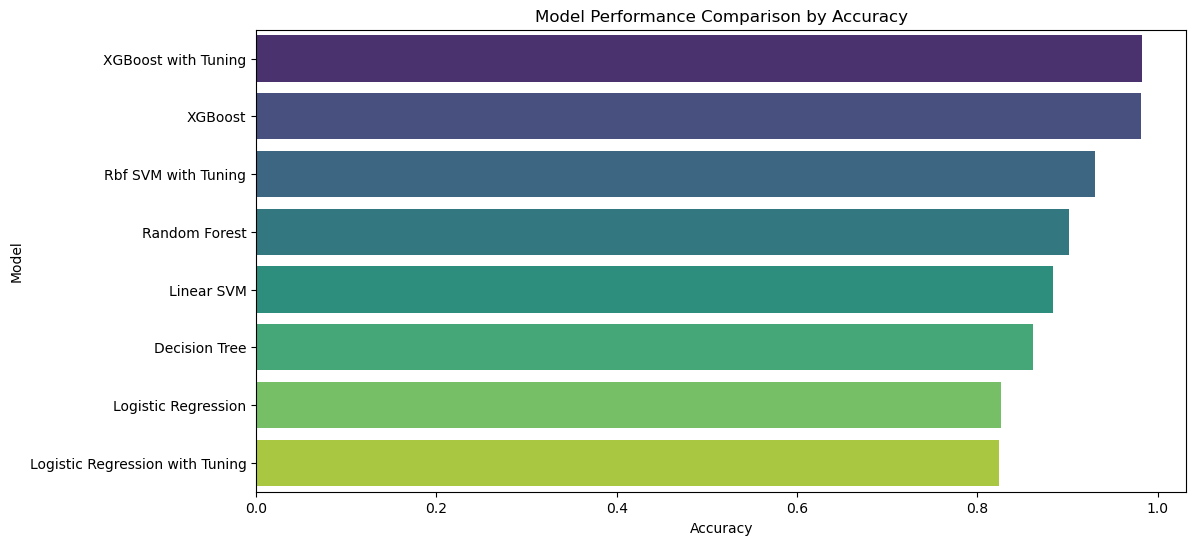

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by Accuracy in ascending order
sorted_df = performance_df.sort_values(by="Accuracy", ascending=False)

plt.figure(figsize=(12, 6))
plt.title("Model Performance Comparison by Accuracy")
sns.barplot(x="Accuracy", y="Model", data=sorted_df, hue="Model", palette="viridis", legend=False)
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.show()

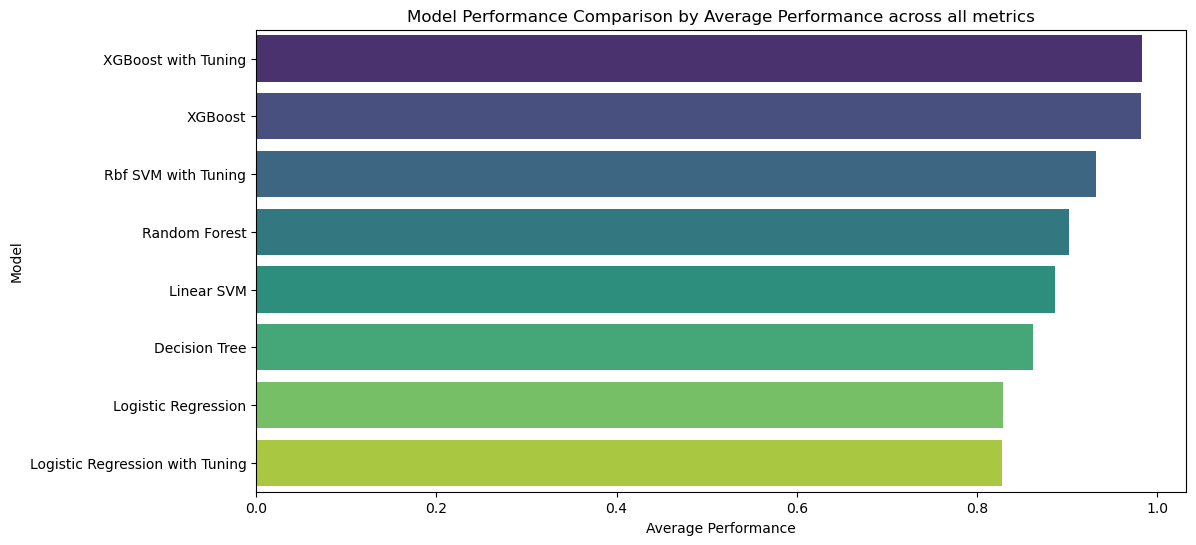

In [184]:
# Calculate average performance across all metrics
performance_df['Avg_Performance'] = performance_df[['Accuracy', 'Precision', 'Recall', 'F1-score']].mean(axis=1)

# Sort by average performance
sorted_df = performance_df.sort_values(by="Avg_Performance", ascending=False)

plt.figure(figsize=(12, 6))
plt.title("Model Performance Comparison by Average Performance across all metrics")
sns.barplot(x="Avg_Performance", y="Model", data=sorted_df, hue="Model", palette="viridis", legend=False)
plt.xlabel("Average Performance")
plt.ylabel("Model")
plt.show()

<Figure size 600x400 with 0 Axes>

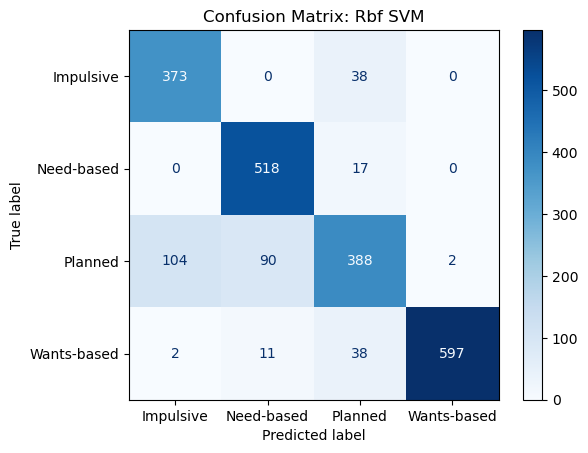

<Figure size 600x400 with 0 Axes>

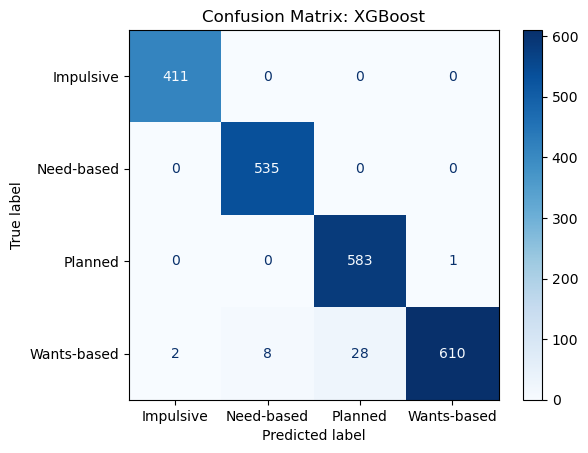

<Figure size 600x400 with 0 Axes>

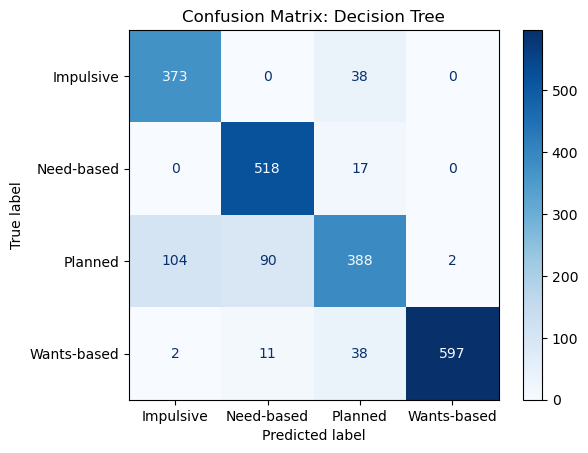

<Figure size 600x400 with 0 Axes>

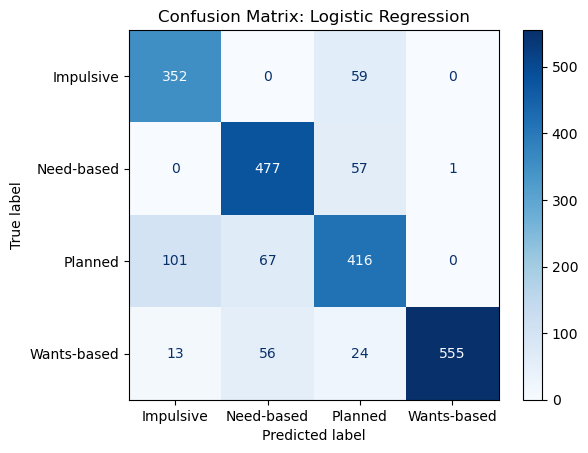

<Figure size 600x400 with 0 Axes>

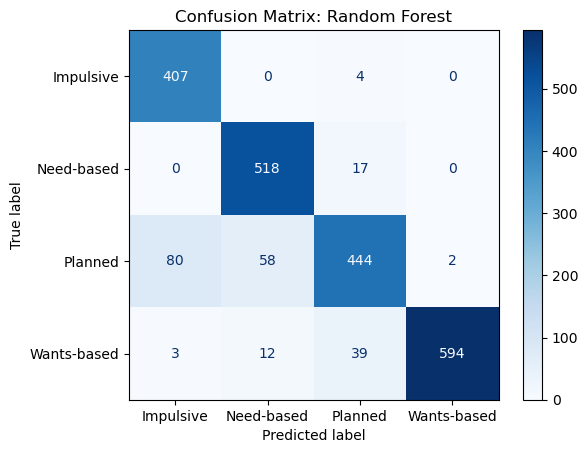

<Figure size 600x400 with 0 Axes>

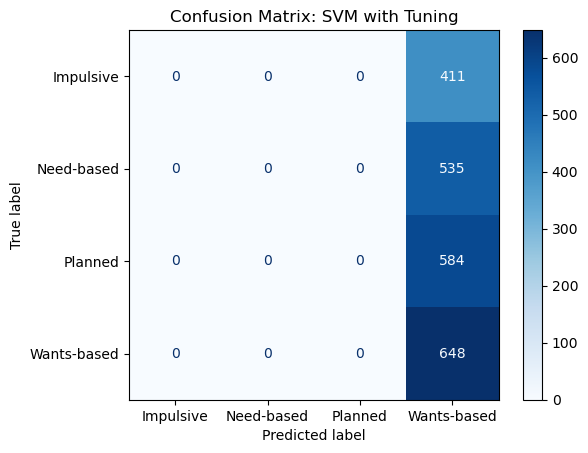

<Figure size 600x400 with 0 Axes>

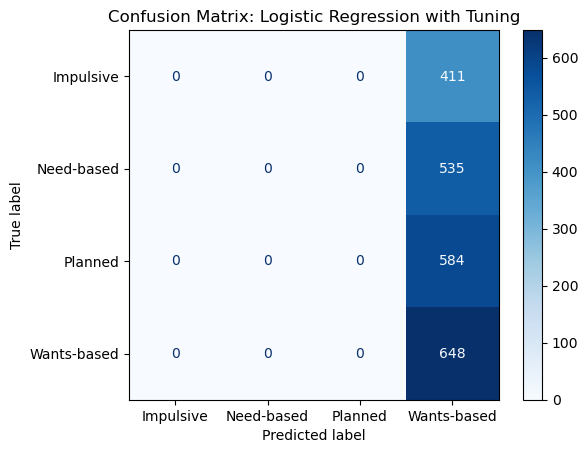

<Figure size 600x400 with 0 Axes>

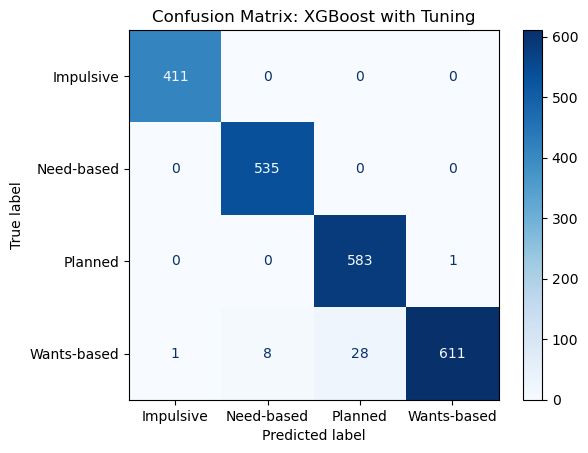

In [185]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prepare a dictionary of model names and their predictions
model_predictions = {
    "Rbf SVM": clf.predict(x_test_scaled),
    "XGBoost": xgb_clf.predict(x_test_scaled),
    "Decision Tree": DecisionTreeModel.predict(x_test_scaled),
    "Logistic Regression": logreg.predict(x_test_scaled),
    "Random Forest": rf_clf.predict(x_test_scaled),
    "SVM with Tuning": best_model.predict(x_test),
    "Logistic Regression with Tuning": best_lr.predict(x_test),
    "XGBoost with Tuning": best_xgb.predict(x_test_scaled)
}

# Get class labels from the label encoder for purchase_intent_category
class_labels = le_dict['Purchase Intent Category'].classes_

# Plot confusion matrix for each model
for model_name, y_pred in model_predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    plt.figure(figsize=(6, 4))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()